# Importing Modules

In [1]:
from os import listdir
from os.path import isdir
from random import choice

from PIL import Image
from matplotlib import pyplot

from numpy import savez_compressed
from numpy import asarray
from numpy import load
from numpy import expand_dims

from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

import pickle

dataset_folder = 'Celebrity Faces Dataset'
facenet_model = load_model('keras-facenet/model/facenet_keras.h5', compile=False)

# Functions for extracting faces and creating embeddings

In [6]:
# create the detector, using default weights
detector = MTCNN()
    
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# Loading and Saving Dataset as npz

In [7]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [8]:
# load train dataset
trainX, trainy = load_dataset(dataset_folder+'/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(dataset_folder+'/test/')
# save arrays to one file in compressed format
savez_compressed('celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 31 examples for class: Alejandro_Toledo
>loaded 28 examples for class: Alvaro_Uribe
>loaded 28 examples for class: Andre_Agassi
>loaded 61 examples for class: Ariel_Sharon
>loaded 33 examples for class: Arnold_Schwarzenegger
>loaded 24 examples for class: David_Beckham
>loaded 35 examples for class: Gloria_Macapagal_Arroyo
>loaded 31 examples for class: Hans_Blix
>loaded 56 examples for class: Hugo_Chavez
>loaded 41 examples for class: Jacques_Chirac
>loaded 44 examples for class: Jean_Chretien
>loaded 33 examples for class: Jennifer_Capriati
>loaded 42 examples for class: John_Ashcroft
>loaded 24 examples for class: John_Negroponte
>loaded 48 examples for class: Junichiro_Koizumi
>loaded 25 examples for class: Kofi_Annan
>loaded 32 examples for class: Laura_Bush
>loaded 32 examples for class: Lleyton_Hewitt
>loaded 38 examples for class: Luiz_Inacio_Lula_da_Silva
>loaded 26 examples for class: Megawati_Sukarnoputri
>loaded 29 examples for class: Nestor_Kirchner
>loaded 25 exam

# Creating Embeddings from Saved Dataset

In [9]:
# load the face dataset
data = load('celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(facenet_model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(facenet_model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (923, 160, 160, 3) (923,) (247, 160, 160, 3) (247,)
(923, 128)
(247, 128)


# SVC Model

In [2]:
# load dataset
data = load('celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)

# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=923, test=247
Accuracy: train=99.783, test=98.381


In [11]:
f = open("facenet_model", "wb")
f.write(pickle.dumps(model))
f.close()

In [12]:
model = pickle.loads(open('facenet_model', "rb").read())

# Random Testing

Predicted: Alejandro_Toledo (13.895)
Expected: Hugo_Chavez


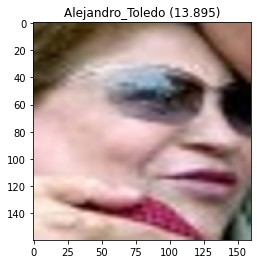

In [31]:
# load faces
data = load('celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

# load face embeddings
data = load('celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()